# Seminario de Ciencia de Datos - Trabajo práctico 3
### de la Fuente, Alethia- Hesse, Eugenia -  Baglivo, Fabricio

#### Configuraciones generales

In [3]:
from scipy.io import loadmat
from scipy.signal import welch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 
import pandas as pd
import seaborn as sns
from scipy import stats
import os
from scipy import ndimage

# Log Reg
import numpy as np
from scipy import interp
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from  scipy import stats

# For SVM
from sklearn.datasets import samples_generator
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import preprocessing

# For SVM - Standarization
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

#path de los archivos
#path_to_files = 'C:\\Users\\Fabri\\Documents\\Documentos\\PhD\\Cursos\\SeminarioCienciaDeDatos\\TP3\\'
path_to_files = 'G:\\Cursos Doctorado\\CienciaDeDatos\\2.SeriesTemporales\\datos\\'
#path_to_files = 'C:\\Users\\Amelie\\Documents\\Cursos\\CienciadeDatos\\TP2_seriestemporales\\datos\\'

#se crearon subcarpetas para los sujetos normales y los pacientes
p_to_files = path_to_files + 'p\\'
s_to_files = path_to_files + 's\\'

# caracteristicas de los datos
# dim 1 = epocas, dim 2 = electrodos, dim 3 = tiempo
# duracion de cada epoca 0.8 secs, 200 ms baseline
# 250 frecuencia de muestreo

epoch_time = 0.8

### 2. Construcción de data frame con todas las features
#### Potencia para cada banda de frecuencia (Delta, Theta, Alpha, Beta y Gamma)

In [4]:
#Definicion de funciones para el cálculo de la potencia espectral

#Calcula el espectro frecuencial de data (epochs,time) con el método de Welch y
#devuelve un vector de frecuencias y una matriz con los resultados espectrales (frecuencias,trials). 
def welch_by_trial(data,epoch_time):      
    #INPUT:
    #   * data: matriz de valores (epochs, time)
    #   * epoch_time: duración del epoch en segundos
    #OUTPUT:
    #   * freq: vector de frecuencias
    #   * pxx: matriz de potencias espectrales
    
    pxx = np.empty([])    
    for trial in range(len(data)):           
        freq,e_pxx = welch(data[trial,:],fs = data.shape[1]/epoch_time, window='hamming') #calculo de la potencia espectral
        if trial == 0:
            pxx = np.empty((len(freq),len(data)))            
        pxx[:,trial] = e_pxx
         
    return [freq,pxx]

# Devuelve los indices del rango de frecuencias indicado
def get_band_indexes(F,band):
    #INPUT:
    #   * F: vector de frecuencias
    #   * band: vector de dos valores que indican el rango de frecuencias.
    #OUTPUT:
    #   * vector con los indices correspondientes al rango indicado del vector de frecuencias.
    
    filter1 = abs(F - band.min())
    c1 = filter1.min()
    inddase1 = np.where(filter1 == c1)[0]
    filter2 = abs(F - band.max())
    c2 = filter2.min()
    inddase2 = np.where(filter2 == c2)[0]
    return inddase1[0],inddase2[0]

#Calcula las potencias for rangos de frecuencias y sus valores normalizados utilizando el método de welch.
#Bandas frecuenciales consideradas:
    # Delta: < 4 Hz
    # Theta: 4 - 8 Hz
    # Alpha: 8 - 13 Hz
    # Beta: 13 - 30 Hz
    # Gamma: > 30 Hz
#Primero calcula la media de los canales, y luego calcula la potencia por epoch/trial
def welch_freq_bands_for_subjects(path_to_files,epoch_time,group,selected_channels):
    # INPUTS:
    #       * path_to_files: directorio en el que se encuentran los archivos
    #       * epoch_time: duración de la epoch en segundos 
    #       * group: letra que identifica al grupo sobre el que se realiza el cálculo
    #       * selected_channels: los canales sobre los que se realiza el promedio
    #OUTPUTS: 
    #       * Devuelve un data frame (pandas) que contienen:
    #         - la media de la potencia de los trials de cada banda de frecuencia por sujeto, 
    #         - el desvío de los trials de cada banda de frecuencia por sujeto,
    #         - la media normalizada de la potencia de los trials de cada banda de frecuencia por sujeto, 
    #         - el desvío normalizado de los trials de cada banda de frecuencia por sujeto.
        
    #lista de los archivos/sujetos en el directorio
    files = os.listdir(path_to_files)  
    suj_nr = len(files)    
    
    #inicialización de las variables resultado
    suj_mean_freq_bands = np.empty((suj_nr, 5))  #5 -> el número de bandas de frecuencia: Delta, Theta, Alpha, Beta y Gamma
    suj_sd_freq_bands = np.empty((suj_nr, 5))  
    norm_suj_mean_freq_bands = np.empty((suj_nr, 5))  
    norm_suj_sd_freq_bands = np.empty((suj_nr, 5))  
    
    for s_nr in range(0,suj_nr):  
        #carga de matriz
        data = loadmat(path_to_files + files[s_nr])['data'] # epoch,electrodes,time
        grand_average = np.mean(data[:,selected_channels,:],1) # promedio de todos los canales seleccioados 
        [freq,pxx] = welch_by_trial(grand_average,epoch_time) # calculo de la potencia espectral por trial
        
        #Se obtienen los indices de los rangos frecuenciales
        #Delta < 4 Hz
        deltai,deltaf = get_band_indexes(freq,np.array([0,4]))
        #4 Hz <= Theta < 8 Hz
        therai, theraf = get_band_indexes(freq,np.array([4,8]))
        #8 Hz <= Alpha < 13 Hz
        alphai,alphaf = get_band_indexes(freq,np.array([8,13]))
        #13 Hz <= Beta < 30 Hz
        betai,betaf = get_band_indexes(freq,np.array([13,30]))
        #30 Hz <= Gamma < Nyquist
        gammai,gammaf = get_band_indexes(freq,np.array([30,45]))
        
        #se promedian los valores espectrales para el rango de frecuencias por trial, y luego se promedian los trials 
        #para cada banda de frecuencia        
        suj_mean_freq_bands[s_nr,0]= np.mean(np.mean(pxx[range(deltai,deltaf),:],axis=0))
        suj_mean_freq_bands[s_nr,1]= np.mean(np.mean(pxx[range(therai,theraf),:],axis=0))
        suj_mean_freq_bands[s_nr,2]= np.mean(np.mean(pxx[range(alphai,alphaf),:],axis=0))
        suj_mean_freq_bands[s_nr,3]= np.mean(np.mean(pxx[range(betai,betaf),:],axis=0))
        suj_mean_freq_bands[s_nr,4]= np.mean(np.mean(pxx[range(gammai,gammaf),:],axis=0))

        suj_sd_freq_bands[s_nr,0]= np.std(np.mean(pxx[range(deltai,deltaf),:],axis=0))
        suj_sd_freq_bands[s_nr,1]= np.std(np.mean(pxx[range(therai,theraf),:],axis=0))
        suj_sd_freq_bands[s_nr,2]= np.std(np.mean(pxx[range(alphai,alphaf),:],axis=0))
        suj_sd_freq_bands[s_nr,3]= np.std(np.mean(pxx[range(betai,betaf),:],axis=0))
        suj_sd_freq_bands[s_nr,4]= np.std(np.mean(pxx[range(gammai,gammaf),:],axis=0))
        
        #potencia normalizada
        total_mean_freq_bands = np.sum(suj_mean_freq_bands[s_nr,:]) #potencia media total        
        norm_suj_mean_freq_bands[s_nr,0]= suj_mean_freq_bands[s_nr,0]/total_mean_freq_bands
        norm_suj_mean_freq_bands[s_nr,1]= suj_mean_freq_bands[s_nr,1]/total_mean_freq_bands
        norm_suj_mean_freq_bands[s_nr,2]= suj_mean_freq_bands[s_nr,2]/total_mean_freq_bands
        norm_suj_mean_freq_bands[s_nr,3]= suj_mean_freq_bands[s_nr,3]/total_mean_freq_bands
        norm_suj_mean_freq_bands[s_nr,4]= suj_mean_freq_bands[s_nr,4]/total_mean_freq_bands

        total_sd_freq_bands = np.sum(suj_sd_freq_bands[s_nr,:]) #sd de potencia total
        norm_suj_sd_freq_bands[s_nr,0]= suj_sd_freq_bands[s_nr,0]/total_sd_freq_bands
        norm_suj_sd_freq_bands[s_nr,1]= suj_sd_freq_bands[s_nr,1]/total_sd_freq_bands
        norm_suj_sd_freq_bands[s_nr,2]= suj_sd_freq_bands[s_nr,2]/total_sd_freq_bands
        norm_suj_sd_freq_bands[s_nr,3]= suj_sd_freq_bands[s_nr,3]/total_sd_freq_bands
        norm_suj_sd_freq_bands[s_nr,4]= suj_sd_freq_bands[s_nr,4]/total_sd_freq_bands

    suj_freq_bands_df = pd.DataFrame({'Grupo' : group, 
                                      'MeanDelta' : suj_mean_freq_bands[:,0],'MeanTheta' : suj_mean_freq_bands[:,1],'MeanAlpha' :suj_mean_freq_bands[:,2], 'MeanBeta' : suj_mean_freq_bands[:,3],'MeanGamma' : suj_mean_freq_bands[:,4], 
                                      'StdDelta' : suj_sd_freq_bands[:,0],'StdTheta' : suj_sd_freq_bands[:,1],'StdAlpha' : suj_sd_freq_bands[:,2], 'StdBeta' : suj_sd_freq_bands[:,3],'StdGamma' : suj_sd_freq_bands[:,4],
                                      'NormMeanDelta' : norm_suj_mean_freq_bands[:,0],'NormMeanTheta' : norm_suj_mean_freq_bands[:,1],'NormMeanAlpha' : norm_suj_mean_freq_bands[:,2], 'NormMeanBeta' : norm_suj_mean_freq_bands[:,3],'NormMeanGamma' : norm_suj_mean_freq_bands[:,4],
                                      'NormStdDelta' : norm_suj_sd_freq_bands[:,0],'NormStdTheta' : norm_suj_sd_freq_bands[:,1],'NormStdAlpha' : norm_suj_sd_freq_bands[:,2], 'NormStdBeta' : norm_suj_sd_freq_bands[:,3],'NormStdGamma' : norm_suj_sd_freq_bands[:,4]})
        
    return suj_freq_bands_df

#### Medidas de información intra e inter electrodos

In [5]:
#Definicion de funciones para el análisis de la información

#Medida de información intra - electrodo -> entropía
#Calcula la entropia por cada canal para cada trial.
def entropy_intra_electrode(data):    
    # INPUTS:
    #       * data: matriz con los valores 
    #OUTPUTS: 
    #       * Devuelve una matriz con los valores de entropia para cada canal por trial
    
    entropy = np.empty((data.shape[0],data.shape[1]))
    for channel in range(data.shape[1]):            
        for trial in  range(data.shape[0]):
            zscored = stats.zscore(data[trial,channel,:])
            [n,bins] = np.histogram(zscored,bins=5)
#            [n,bins] = np.histogram(zscored)
            entropy[trial,channel] = stats.entropy(n)
              
    return entropy

#Calcula la entropia para todos los sujectos/archivos en el directorio, para todos los canales y trials.
def entropy_intra_electrode_for_subjects(path_to_files,selected_channels):
    # INPUTS:
    #       * path_to_files: directorio en el que se encuentran los archivos de los sujetos
    #       * selected_channels: indices de los canales seleccionados
    #OUTPUTS: 
    #       * Devuelve un data frame con la media y desvio de entropia
    
    files = os.listdir(path_to_files)  
    suj_nr = len(files)
    entropy_for_sujs = np.empty((suj_nr))
    entropy_for_sujs_sd = np.empty((suj_nr))
    for s_nr in range(0,suj_nr):        
        data = loadmat(path_to_files + files[s_nr])['data'] # epoch,electrodes,time
        selected_data = data[:,selected_channels,:]        
        suj_entropy = entropy_intra_electrode(selected_data)
        entropy_for_sujs[s_nr] = np.mean(suj_entropy)
        entropy_for_sujs_sd[s_nr] = np.std(suj_entropy)
        
    entropy_df = pd.DataFrame({'Grupo' : 'p','MeanEntropia':entropy_for_sujs,'StdEntropia':entropy_for_sujs_sd})
    
    return entropy_df

#Medida de información inter - electrodo -> Información Mutua
EPS = np.finfo(float).eps

"""
 Taken from https://gist.github.com/GaelVaroquaux/ead9898bd3c973c40429
"""

def mutual_information_2d(x, y, sigma=1, normalized=False):
    """
    Computes (normalized) mutual information between two 1D variate from a
    joint histogram.
    Parameters
    ----------
    x : 1D array
        first variable
    y : 1D array
        second variable
    sigma: float
        sigma for Gaussian smoothing of the joint histogram
    Returns
    -------
    nmi: float    
        the computed similariy measure
    """
    bins = (256, 256)

    jh = np.histogram2d(x, y, bins=bins)[0]

    # smooth the jh with a gaussian filter of given sigma
    ndimage.gaussian_filter(jh, sigma=sigma, mode='constant',
                                 output=jh)

    # compute marginal histograms
    jh = jh + EPS
    sh = np.sum(jh)
    jh = jh / sh
    s1 = np.sum(jh, axis=0).reshape((-1, jh.shape[0]))
    s2 = np.sum(jh, axis=1).reshape((jh.shape[1], -1))

    # Normalised Mutual Information of:
    # Studholme,  jhill & jhawkes (1998).
    # "A normalized entropy measure of 3-D medical image alignment".
    # in Proc. Medical Imaging 1998, vol. 3338, San Diego, CA, pp. 132-143.
    if normalized:
        mi = ((np.sum(s1 * np.log(s1)) + np.sum(s2 * np.log(s2)))
                / np.sum(jh * np.log(jh))) - 1
    else:
        mi = ( np.sum(jh * np.log(jh)) - np.sum(s1 * np.log(s1))
               - np.sum(s2 * np.log(s2)))

    return mi

#Calcula informacion mutua para todos los sujetos/archivos en un directorio, 
#para todos los pares de canales y todos los trials, y devuelva la media y desvío de todo el promedio por sujeto.
def mutual_information_inter_electrode_for_subjects(path_to_files,group,selected_channels):
    # INPUTS:
    #       * path_to_files: matriz con los valores (epoch,electrodes,time)
    #       * group: letra que identifica el grupo de los datos
    #       * selected_channels: indices de los canales seleccionados
    #OUTPUTS: 
    #       * Devuelve un data frame con la media y desvio del mutual information 

    files = os.listdir(path_to_files)  
    suj_nr = len(files)
    mean_mutual_information = np.empty((suj_nr))
    std_mutual_information = np.empty((suj_nr))
    for s_nr in range(0,suj_nr):        
        data = loadmat(path_to_files + files[s_nr])['data'] # epoch,electrodes,time
        selected_data = data[:,selected_channels,:]
        
        mi=np.zeros((selected_data.shape[0],sum(range(0,len(selected_channels)+1))),dtype=float)
        index=0
        for trial in  range(1): #range(selected_data.shape[0]):
            for channel in range(selected_data.shape[1]):                
                for channel2 in range(channel,selected_data.shape[1]):            
                    mi[trial,index] = mutual_information_2d(selected_data[trial,channel,:],selected_data[trial,channel2,:])
                    index=index+1
                    
                    
        mean_mutual_information[s_nr] = np.mean(np.mean(mi,axis=0))
        std_mutual_information[s_nr] = np.std(np.mean(mi,axis=0))                
    
    mi_df = pd.DataFrame({'Grupo' : group,'MeanMutualInformation': mean_mutual_information,'StdMutualInformation': std_mutual_information})    
    return mi_df

#### Creación del Data Frame con los 24 features + grupo

In [6]:
#GENERACION DEL DATA FRAME CON TODOS LOS FEATURES

selected_channels = [8,44,80,131,185] #canales especificados
selected_channels_indx = np.array(selected_channels) - 1 #indices de los canales especificados
#selected_channels_indx = range(256) 

#Potencia espectral
p_freq_bands = welch_freq_bands_for_subjects(p_to_files,epoch_time,'p',selected_channels_indx) #en este data frame se encuentran los valores de cada banda para cada paciente   
s_freq_bands = welch_freq_bands_for_subjects(s_to_files,epoch_time,'s',selected_channels_indx) #en este data frame se encuentran los valores de cada banda para cada paciente   

#Análisis de Información intra electrodo -> entropia
p_entropy_sujs_df  = entropy_intra_electrode_for_subjects(p_to_files,selected_channels_indx)
s_entropy_sujs_df = entropy_intra_electrode_for_subjects(s_to_files,selected_channels_indx)

#Análisis de Información inter electrodo -> información mutua
p_mi_sujs_df = mutual_information_inter_electrode_for_subjects(p_to_files,'p',selected_channels_indx)    
s_mi_sujs_df = mutual_information_inter_electrode_for_subjects(s_to_files,'s',selected_channels_indx)  

#Unifico todos los resultados en un único data frame
#junto todo para pacientes
cols_to_use = p_entropy_sujs_df.columns.difference(p_freq_bands.columns)
p_features = pd.merge(p_freq_bands,p_entropy_sujs_df[cols_to_use],left_index=True, right_index=True, how='outer')
cols_to_use = p_mi_sujs_df.columns.difference(p_features.columns)
p_features = pd.merge(p_features,p_mi_sujs_df[cols_to_use],left_index=True, right_index=True, how='outer')

#junto todo para sujetos
cols_to_use = s_entropy_sujs_df.columns.difference(s_freq_bands.columns)
s_features = pd.merge(s_freq_bands,s_entropy_sujs_df[cols_to_use],left_index=True, right_index=True, how='outer')
cols_to_use = s_mi_sujs_df.columns.difference(s_features.columns)
s_features = pd.merge(s_features,s_mi_sujs_df[cols_to_use],left_index=True, right_index=True, how='outer')

#junto pacientes y sujetos 
features_df = pd.concat([p_features,s_features], axis = 0)

print(features_df.shape)

#obtengo la matriz de features y el vector binarizado de grupo
X_all = features_df.loc[:,features_df.columns != 'Grupo'].values #take features
y = features_df.loc[:,features_df.columns == 'Grupo'].values #take labels
feature_cols = [i for i in list(features_df.columns) if i != 'Grupo']

lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(y)
c,r = y.shape
y = y.reshape(c,)


C:\Users\Becarios\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


(20, 25)


### 2.1 Análisis Univariado
#### a) Para cada feature, computar la curva ROC y graficarla. 

In [13]:
#Definición de la función para el cálculo del ROC
def ROCK (test_df_0):
    # INPUTS:
    #       * test_df tiene en la primer columna el grupo y en la segunda los datos 
    #OUTPUTS: 
    #       * Devuelve: un vector Sensibilidad o Razón de Verdaderos Positivos (VPR)
    #       *           un vector Ratio o Razón de Falsos Positivos (FPR)
    #       *           un vector con los umbrales del corte (u) de largo np.floor(test_df.shape[0]/3)

    test_df = test_df_0.iloc[:,[1]]
    u = np.linspace(np.array(test_df.min()), np.array(test_df.max()),
                    num=np.array( np.floor(test_df.shape[0]/3)))

    # El grupo de referencia es el que tiene el menor valor de la variables
    ref_0 = test_df_0.min()
    ref = test_df_0[(test_df_0.iloc[:,1] == ref_0[1])].Grupo
    Grupos = test_df_0.Grupo.unique()
    menor = np.searchsorted(Grupos, ref)

    test_df_sort = test_df_0.sort_values(by = test_df_0.columns[1], ascending=0).copy()
    totales = np.array(test_df_sort.groupby([test_df_0.columns[0]]).count()) 
    tot_s = totales[0,0]
    tot_p = totales[1,0]
    
    VPR = np.zeros(u.shape[0])
    FPR = np.zeros(u.shape[0])
    
    for i in range(u.shape[0]) :      
        up_u =   test_df_sort[test_df_sort.iloc[:,1]>u[i]].groupby('Grupo').count()
        #    Sensibilidad o Razón de Verdaderos Positivos (VPR): VPR = VP / P = VP / ( VP + FN )
        if menor == 0:
            if 's' in up_u.index:
                VPR[i] = np.array(up_u.loc['s']) / tot_s
            else:
                VPR[i] = np.array(1e-15) / tot_s
            
            #    Ratio o Razón de Falsos Positivos (FPR): FPR = FP / N = FP / ( FP + VN )
            if 'p' in up_u.index:
                FPR[i] = np.array(up_u.loc['p']) / tot_p
            else:
                FPR[i] = np.array(1e-15) / tot_p
                
        elif menor == 1:
            if 'p' in up_u.index:
                VPR[i] = np.array(up_u.loc['p']) / tot_p
            else:
                VPR[i] = np.array(1e-15) / tot_p           
            if 's' in up_u.index:
                FPR[i] = np.array(up_u.loc['s']) / tot_s
            else:
                FPR[i] = np.array(1e-15) / tot_s
        else:
            pass
    return VPR,FPR,u   

C:\Users\Amelie\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


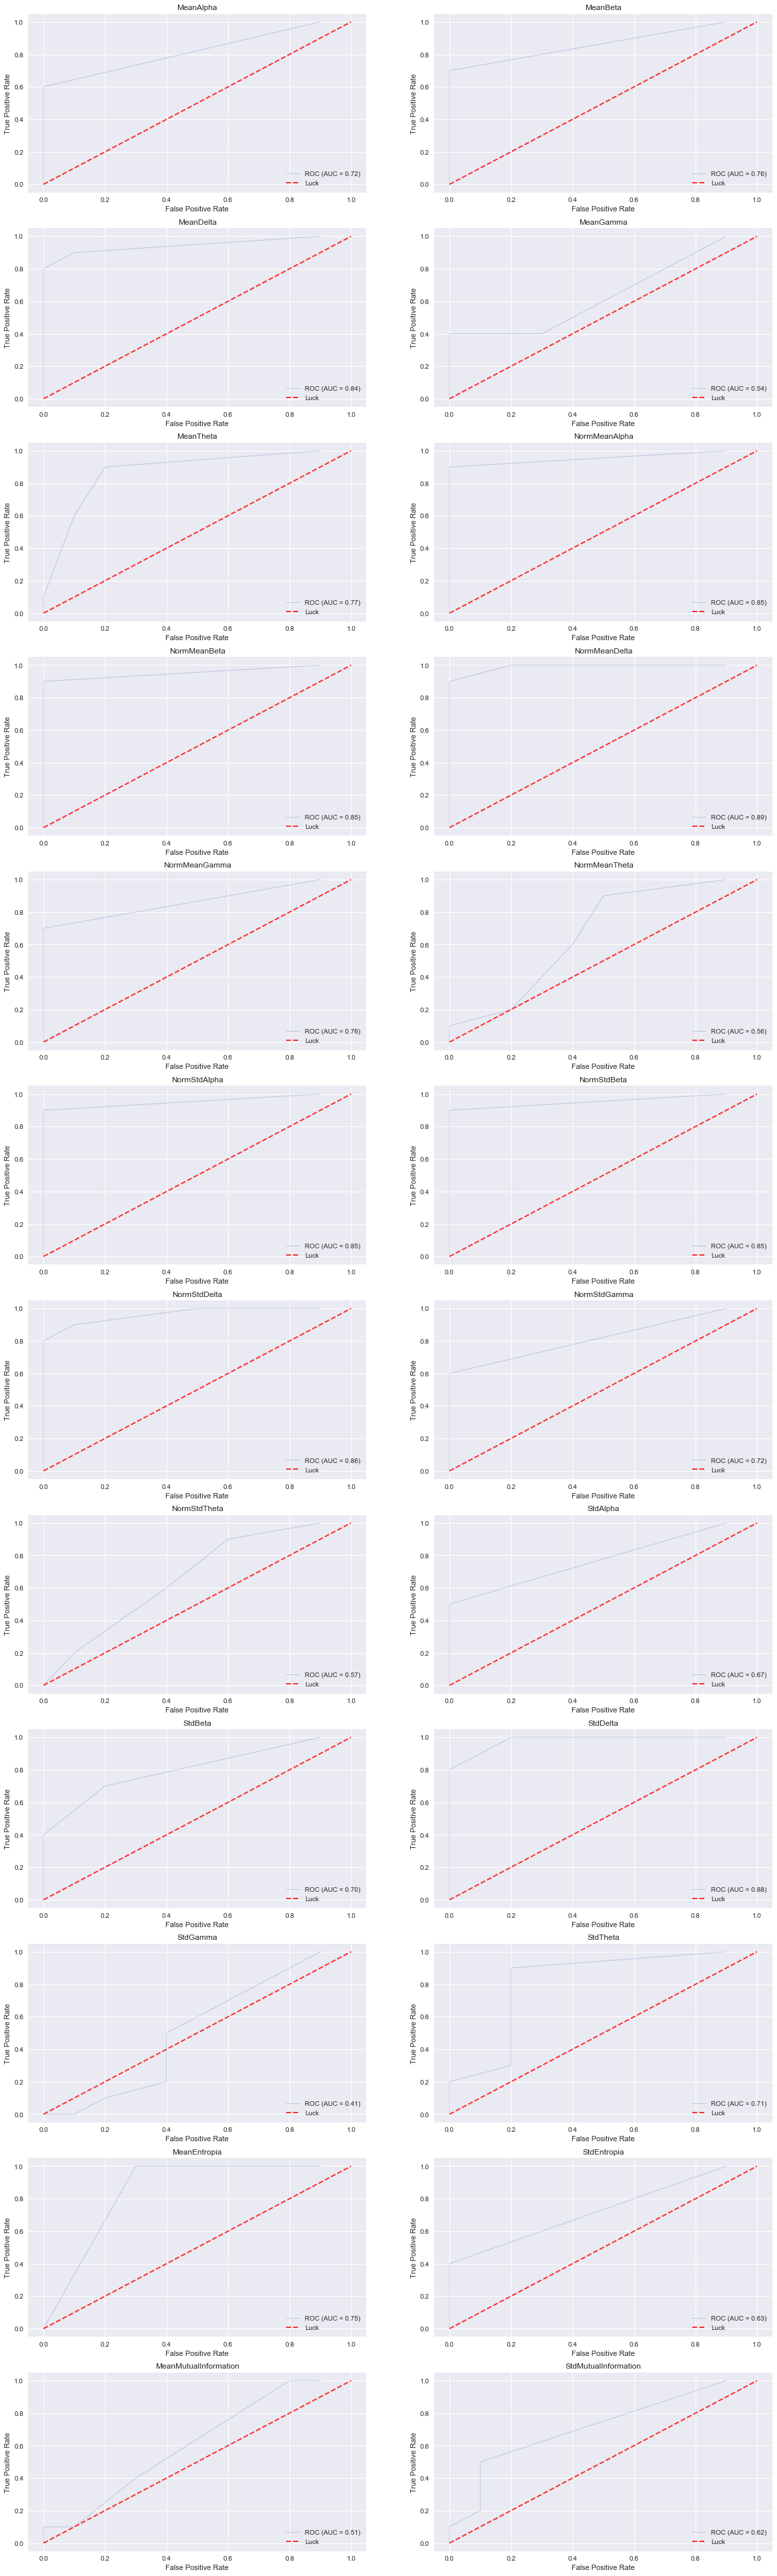

In [16]:
plt.rcParams.update({'figure.figsize': (20.0, 70.0)})

#feature_cols = [i for i in list(features_df.columns) if i != 'Grupo']

plot_dim1 = 12
plot_dim2 = 2

# ROC analysis

# plot ROC curves
fig, axarr = plt.subplots(plot_dim1,plot_dim2, sharey=True) 

for col in range(0,len(feature_cols)):
     
    plt.subplot(plot_dim1,plot_dim2,col+1)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    # Compute ROC curve and area the curve
    test_df_0 = features_df.iloc[:,[0,col+1]]
    tpr,fpr,u = ROCK(test_df_0)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC (AUC = %0.2f)' % (roc_auc))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)


    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(feature_cols[col])
    plt.legend(loc="lower right")
plt.show()


#### b) Utilizando una técnica de cross validación, estimar la performance de un classificador Logistic Regression para cada feature y graficar la curva ROC correspondiente. ¿Cuál es su conclusión respecto a los resultados obtenidos en el punto anterior? 

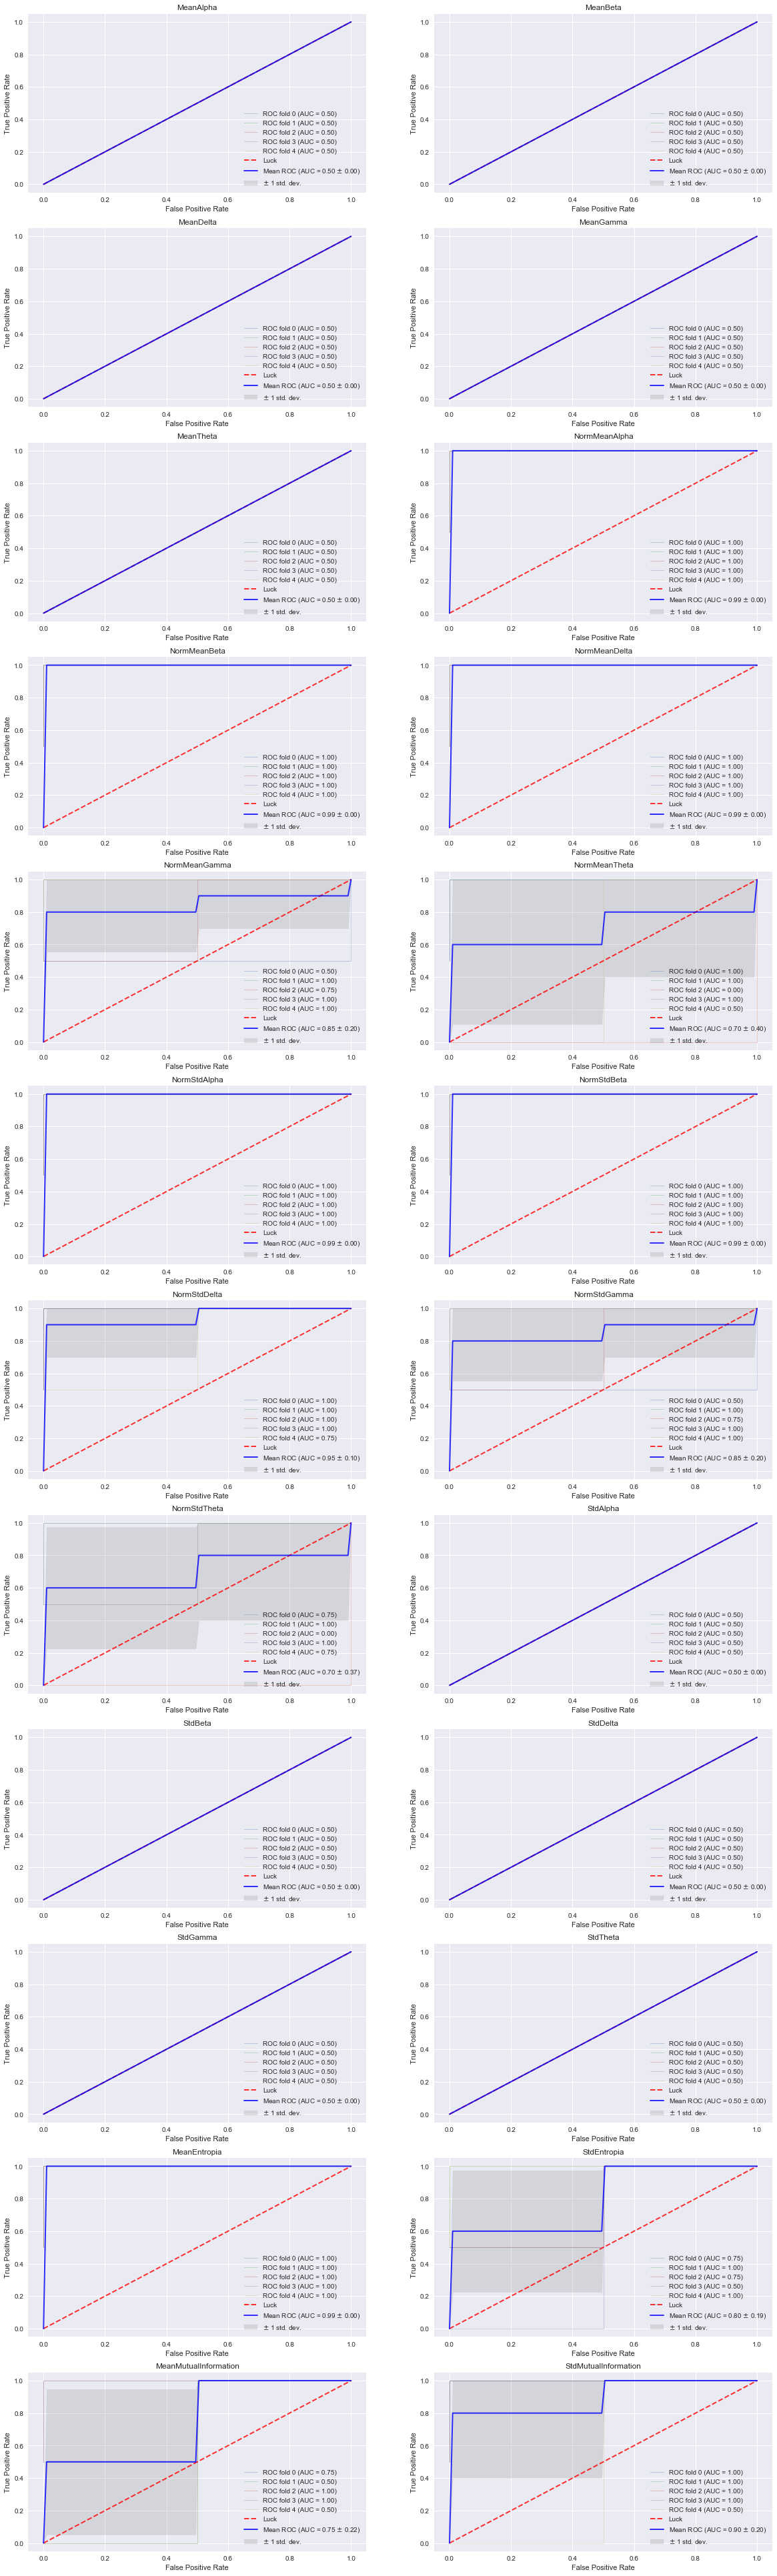

In [91]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': (20.0, 70.0)})

#feature_cols = [i for i in list(features_df.columns) if i != 'Grupo']

plot_dim1 = 12
plot_dim2 = 2

#El siguiente código pertenece a de http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
#y fue modificado parcialmente
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier = LogisticRegression()
fig, axarr = plt.subplots(plot_dim1,plot_dim2, sharey=True) 

for col in range(0,len(feature_cols)):
     
    X = features_df.ix[:, feature_cols[col]].as_matrix()
    X = X.reshape((X.shape[0],1))
    
    plt.subplot(plot_dim1,plot_dim2,col+1)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)        
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(feature_cols[col])
    plt.legend(loc="lower right")
plt.show()

#### Respecto del punto anterior, los resultados de las curvas ROC con cross validation muestran que para las medidas de potencia espectral sin normalización, empeoraron bastante, dando que la clasificación está a nivel de chance. En cambio, las normalizadas mejoraron muchísimo, al punto de sospechar de overfitting.

### 2.2 Análisis Multivariado
#### a) Utilizar todos los features y entrenar un clasificador basado en Support Vector Machine. Computar la curva roc y graficarla. No olvidar reportar el area bajo la curva.

(20, 24)
ROC Score:
0.9
[ 0.  1.]
[ 0.8  1. ]
[1 0]


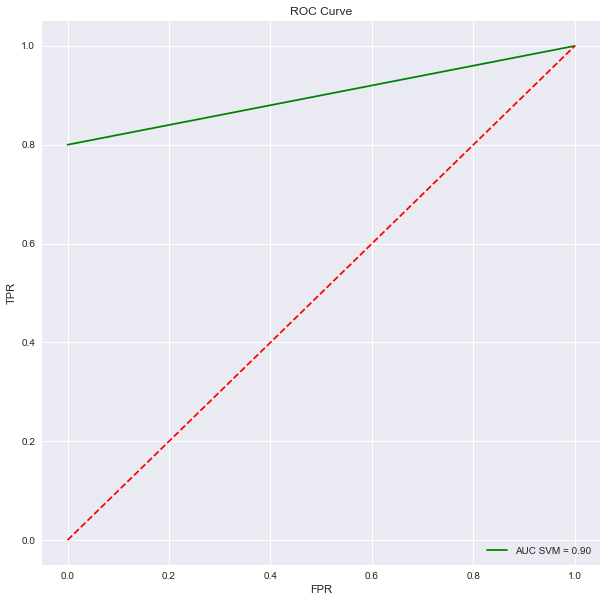

In [103]:
X_all = features_df.loc[:,features_df.columns != 'Grupo'].values #take features
X = X_all

clf = svm.SVC(kernel='linear',probability=True)
scores = cross_val_score(clf, X, y,cv=5)
predicted = cross_val_predict(clf, X, y) #For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.
print('ROC Score:')
print(roc_auc_score(y, predicted))

false_positive_rate, recall, thresholds = roc_curve(y, predicted)
print(false_positive_rate)
print(recall)
print(thresholds)
roc_auc = auc(false_positive_rate, recall)
plt.plot(false_positive_rate, recall, 'g', label = 'AUC %s = %0.2f' % ('SVM', roc_auc))
plt.plot([0,1], [0,1], 'r--')
plt.legend(loc = 'lower right')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve')
plt.show()



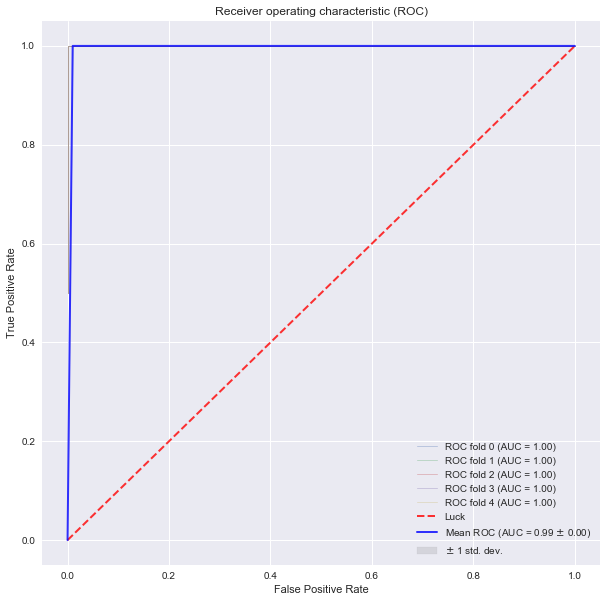

In [104]:
# clf =   svm.SVC()
# scores = cross_val_score(clf, X, y,cv=5)
# predicted = cross_val_predict(clf, X, y) #For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.
# print('ROC Score:')
# print(roc_auc_score(y, predicted))

# false_positive_rate, recall, thresholds = roc_curve(y, predicted)
# roc_auc = auc(false_positive_rate, recall)
# plt.plot(false_positive_rate, recall, 'g', label = 'AUC %s = %0.2f' % ('SVM', roc_auc))
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 10.0)})

cv = StratifiedKFold(n_splits=5)
classifier = svm.SVC(kernel='linear',probability=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)        
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

#### b) Repetir el punto a), pero utilizando un pipeline de Scikit-Learn con los siguientes 3 pasos:

##### Standard Scaler
##### Feature Selection utilizando solo el 10%.
##### SVC
##### ¿Qué diferencia encuentra? ¿Y si utilizamos el 20% de los features? ¿Qué pasa si probamos y encontramos que utilizando el 35% de los features obtenemos la mejor AUC?

ROC Score:
0.94


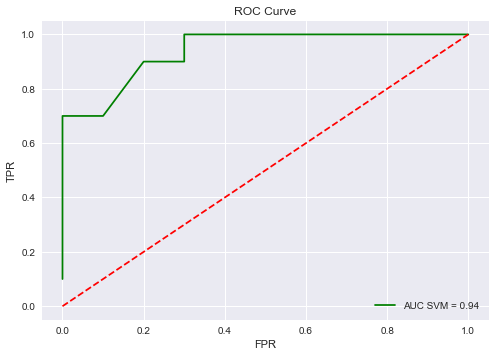

In [7]:
# Second approach
X = X_all

# create feature union
features = []
#features.append(('Scalar', StandardScaler()))
features.append(('select_best', SelectKBest(k=3))) #ROC is Maximun witk k>5 : 24 Features
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('SVC', svm.SVC(kernel='linear',probability=True)))
model = Pipeline(estimators)

# evaluate pipeline
#seed = 3
#kfold = KFold(n_splits=3, random_state=seed)
results = cross_val_score(model, X, y, cv=7)
predicted = cross_val_predict(model, X, y, cv=7,method='predict_proba') #For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.
#print predicted
print('ROC Score:')
print(roc_auc_score(y, predicted[:,1]))

false_positive_rate, recall, thresholds = roc_curve(y, predicted[:,1])
roc_auc = auc(false_positive_rate, recall)
plt.plot(false_positive_rate, recall, 'g', label = 'AUC %s = %0.2f' % ('SVM', roc_auc))
plt.plot([0,1], [0,1], 'r--')
plt.legend(loc = 'lower right')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve')
plt.show()

plt.show()

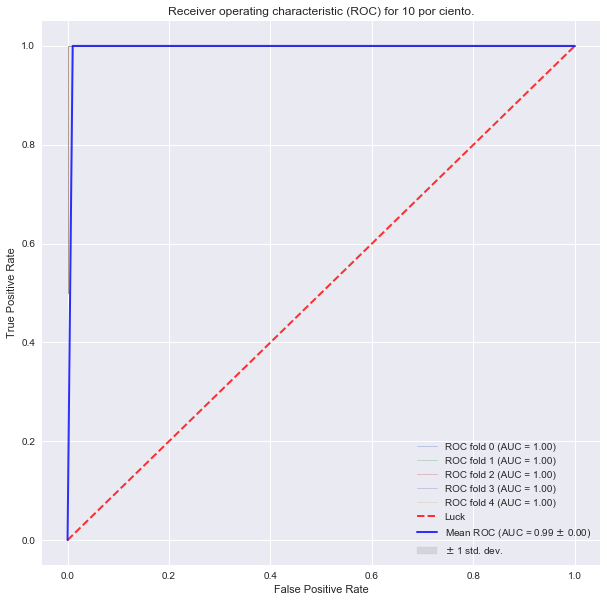

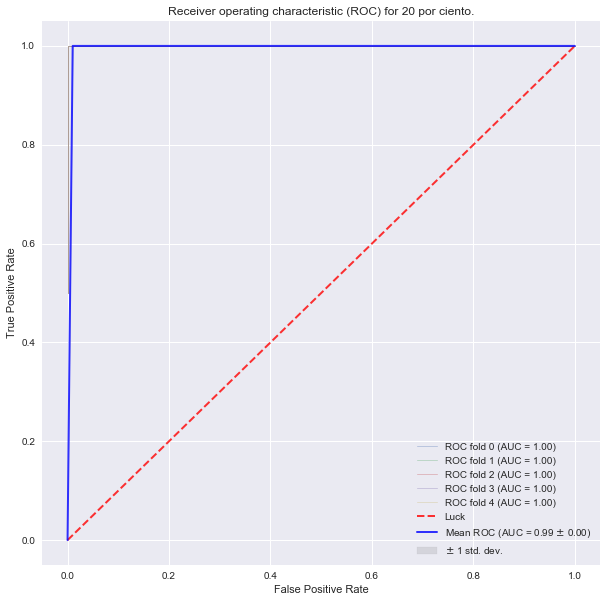

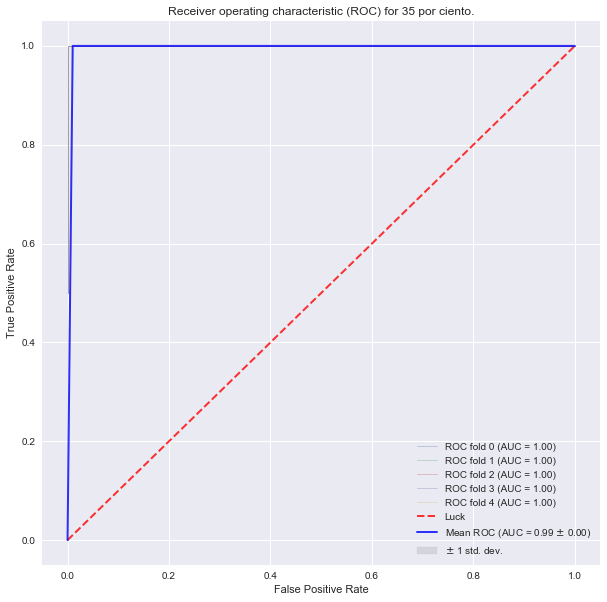

In [123]:
from sklearn import preprocessing
from sklearn.feature_selection import f_classif
import sklearn.feature_selection as fs

X = X_all
percentiles = [10,20,35]

for p in range(0,len(percentiles)):
    percentile_value = percentiles[p]

    #standard scaler
    scaler = preprocessing.StandardScaler()
    
    #feature selection
    percentile_filter = fs.SelectPercentile(f_classif, percentile=percentile_value)

    #svc
    clf = svm.SVC(kernel='linear',probability=True)

    model = Pipeline([('scaler', scaler), ('percentile', percentile_filter),('svc',clf)])

    cv = StratifiedKFold(n_splits=5)
    i = 0
    for train, test in cv.split(X, y):
        probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)        
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(r'Receiver operating characteristic (ROC) for %d por ciento.'%(percentile_value))
    plt.legend(loc="lower right")
    plt.show()

#### Conclusión: Implementamos el gráfico por dos métodos diferentes en este último punto. Los dos nos dan diferentes, y no tenemos del todo claro el por qué. Sin embargo, ambos muestran un gran poder de clasificación, al punto de pensar en que hay una situación de overfitting, y si se tomaran más muestras quizás sería difícil la predicción de la clase a la que pertenecen. Principalmente esto se debe a la baja cantidad de muestras (20) en comparación con la cantidad de features (24). Deberíamos contar con por lo menos 2^24 muestras. Al utilizar el standard scaler se evidenció un sobre ajuste muy fuerte (overfitting). 
#### Es difícil especular que los resultados darían mejor con un porcentaje más alto, debido justamente a que ya contamos con resultados casi perfectos. Si la situación fuera que al agregar más features se consigue mejor clasificación, debido al número bajo de muestras, sospecharía de sobreajuste a la muestra puntual.